## Import packages

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

Import Tensorflow and the Keras classes needed to construct our model.

In [2]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

from tensorflow.keras import layers
from tensorflow.keras import Model, metrics
from tensorflow.keras.optimizers import RMSprop, SGD

import os
import zipfile

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Load data

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
train_local_zip = '/content/drive/MyDrive/lulc-tra-val.zip'
zip_ref = zipfile.ZipFile(train_local_zip, 'r')
zip_ref.extractall('/content/sample_data/lulc-tra-val')

test_local_zip = '/content/drive/MyDrive/test.zip'
zip_ref = zipfile.ZipFile(test_local_zip, 'r')
zip_ref.extractall('/content/sample_data/lulc-tra-val/lulc-classificatio')

zip_ref.close()

In [6]:
PATH = '/content/sample_data/lulc-tra-val/lulc-classificatio'

After extracting its contents, assign variables with the proper file path for the training and validation set.

In [7]:
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

In [8]:
train_BarrenLands_dir = os.path.join(train_dir, '1_BarrenLands___jpeg')
validation_BarrenLands_dir = os.path.join(validation_dir, '1_BarrenLands___jpeg')

In [9]:
num_barren_tr = len(os.listdir(train_BarrenLands_dir))
num_barren_val = len(os.listdir(validation_BarrenLands_dir))

print('total training barren images:', num_barren_tr)
print('total validation barren images:', num_barren_val)

total training barren images: 283
total validation barren images: 71


In [10]:
batch_size = 32
img_height = 160
img_width = 160

## Training and Validation Generators

Now that you know the images you are dealing with, it is time for you to code the generators that will fed these images to your Network. For this, complete the `train_val_generators` function below:

**Important Note:** The images have a resolution of 300x300 but the `flow_from_directory` method you will use allows you to set a target resolution. In this case, **set a `target_size` of (150, 150)**. This will heavily lower the number of trainable parameters in your final network, yielding much quicker training times without compromising the accuracy!

In [11]:
# GRADED FUNCTION: train_val_generators
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):
  ### START CODE HERE

  # Instantiate the ImageDataGenerator class 
  # Don't forget to normalize pixel values and set arguments to augment the images 
  train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

  # Pass in the appropriate arguments to the flow_from_directory method
  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=batch_size, 
                                                      class_mode='categorical',
                                                      target_size=(img_width, img_height))

  # Instantiate the ImageDataGenerator class (don't forget to set the rescale argument)
  # Remember that validation data should not be augmented
  validation_datagen = ImageDataGenerator(
      rescale=1./255,
      )

  # Pass in the appropriate arguments to the flow_from_directory method
  validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                batch_size=batch_size, 
                                                                class_mode='categorical',
                                                                target_size=(img_width, img_height))
  ### END CODE HERE
  return train_generator, validation_generator


In [12]:
# Test your generators
train_generator, validation_generator = train_val_generators(train_dir, validation_dir)

Found 8207 images belonging to 29 classes.
Found 2059 images belonging to 29 classes.


**Expected Output:**
```
Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.
```

## Transfer learning - Create the pre-trained model

Download the `inception V3` weights into the `/tmp/` directory:

In [15]:
import tensorflow_hub as hub

m = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_m/feature_vector/2",
                   trainable=False),  # Can be True, see below.
      # Add a fully connected layer with 1024 hidden units and ReLU activation
    layers.Dense(512, activation='relu'),
    # Add a dropout rate of 0. 2
    layers.Dropout(0.2),

    layers.Dense(29, activation='softmax')
])
m.build([None, 480, 480, 3])  # Batch input shape.

In [16]:
m.compile(optimizer='Adam',
          loss='categorical_crossentropy',
          metrics = ['accuracy'])

In [17]:
# Run this and see how many epochs it should take before the callback
# fires, and stops training at 99.9% accuracy
# (It should take a few epochs)
initial_epochs = 5
history = m.fit(train_generator,
                    validation_data = validation_generator,
                    #batch_size = batch_size,
                    #steps_per_epoch = num_barren_tr // batch_size,
                    epochs = initial_epochs,
                    #validation_steps = num_barren_val // batch_size,
                    verbose = 1)

Epoch 1/5
257/257 [==============================] - 139s 422ms/step - loss: 1.4460 - accuracy: 0.5493 - val_loss: 1.0995 - val_accuracy: 0.6314
Epoch 2/5
257/257 [==============================] - 103s 400ms/step - loss: 0.9215 - accuracy: 0.6943 - val_loss: 1.0166 - val_accuracy: 0.6586
Epoch 3/5
257/257 [==============================] - 104s 405ms/step - loss: 0.7909 - accuracy: 0.7269 - val_loss: 0.9696 - val_accuracy: 0.6877
Epoch 4/5
257/257 [==============================] - 101s 394ms/step - loss: 0.7064 - accuracy: 0.7604 - val_loss: 1.0522 - val_accuracy: 0.6833
Epoch 5/5
257/257 [==============================] - 103s 400ms/step - loss: 0.6793 - accuracy: 0.7622 - val_loss: 0.9590 - val_accuracy: 0.6916


The training should have stopped after less than 10 epochs and it should have reached an accuracy over 99,9% (firing the callback). This happened so quickly because of the pre-trained model you used, which already contained information to classify humans from horses. Really cool!

Now take a quick look at the training and validation accuracies for each epoch of training:

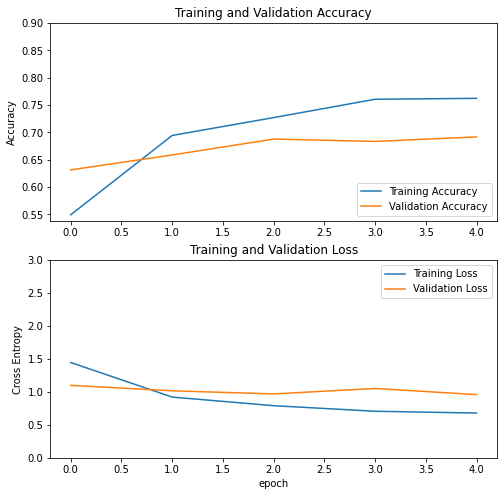

In [18]:
# Plot the training and validation accuracies for each epoch
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),0.9])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,3.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

You will need to submit this notebook for grading. To download it, click on the `File` tab in the upper left corner of the screen then click on `Download` -> `Download .ipynb`. You can name it anything you want as long as it is a valid `.ipynb` (jupyter notebook) file.

**Congratulations on finishing this week's assignment!**

You have successfully implemented a convolutional neural network that leverages a pre-trained network to help you solve the problem of classifying humans from horses.

**Keep it up!**

In [19]:
#Checkpoint In the /output folder
check_filepath = '/content/drive/MyDrive/best_model_lulc_effnet_m_adam.hdf5'
# Keep only a single checkpoint, the best over test accuracy.
checkpoint = tf.keras.callbacks.ModelCheckpoint(check_filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [ ]:
m.trainable = True

m.compile(optimizer=tf.keras.optimizers.Adam(1e-4),  # Low learning rate
          loss = 'categorical_crossentropy', 
          metrics = ['accuracy']
)

history_fine = m.fit(train_generator,
                    validation_data = validation_generator,
                    #batch_size = batch_size,
                    initial_epoch = history.epoch[-1],
                    #steps_per_epoch = num_barren_tr // batch_size,
                    #validation_steps = num_barren_val // batch_size,
                    epochs = 20,
                    verbose = 1,
                    callbacks=[checkpoint])

Epoch 5/20
257/257 [==============================] - ETA: 0s - loss: 2.2917 - accuracy: 0.5177
Epoch 5: val_accuracy improved from -inf to 0.74065, saving model to /content/drive/MyDrive/best_model_lulc_effnet_m_adam.hdf5
257/257 [==============================] - 303s 1s/step - loss: 2.2917 - accuracy: 0.5177 - val_loss: 0.8341 - val_accuracy: 0.7407
Epoch 6/20
257/257 [==============================] - ETA: 0s - loss: 0.9543 - accuracy: 0.6918
Epoch 6: val_accuracy improved from 0.74065 to 0.77125, saving model to /content/drive/MyDrive/best_model_lulc_effnet_m_adam.hdf5
257/257 [==============================] - 266s 1s/step - loss: 0.9543 - accuracy: 0.6918 - val_loss: 0.6983 - val_accuracy: 0.7712
Epoch 7/20
257/257 [==============================] - ETA: 0s - loss: 0.6930 - accuracy: 0.7626
Epoch 7: val_accuracy improved from 0.77125 to 0.79116, saving model to /content/drive/MyDrive/best_model_lulc_effnet_m_adam.hdf5
257/257 [==============================] - 267s 1s/step - los

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

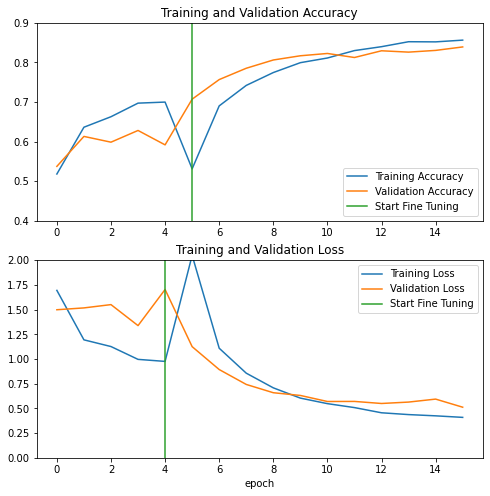

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.4, 0.9])
plt.plot([5,5],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 2.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
def test_generate(TEST_DIR):
  test_datagen = ImageDataGenerator(
      rescale=1./255)

  # Pass in the appropriate arguments to the flow_from_directory method
  test_generator = test_datagen.flow_from_directory(directory=TEST_DIR,
                                                      class_mode='categorical',
                                                      batch_size = 1,
                                                      target_size=(img_width, img_height),
                                                      shuffle = False,
                                                      classes=['.'])
  return test_generator

In [ ]:
test_generator = test_generate(test_dir)

Found 1618 images belonging to 1 classes.


In [ ]:
dictionary = {0 : 10, 1 : 11, 2 : 12, 3 : 13, 4 : 14, 5 : 15, 6 : 16, 7 : 17, 8 : 18, 9 : 19, 10 : 1, 11 : 20, 12 : 21, 13 : 22, 14 : 23, 15 : 24, 16 : 25, 17 : 26, 18 : 27, 19 : 28, 20 : 29, 21 : 2, 22 : 3, 23 : 4, 24 : 5, 25 : 6, 26 : 7, 27 : 8, 28 : 9}

In [ ]:
m.load_weights(check_filepath)

predict_proba = m.predict(test_generator)
predict = np.argmax(predict_proba, axis = 1)
predict = np.vectorize(dictionary.get)(predict)

In [ ]:
submission = pd.DataFrame()

filenames = list()
for filename in test_generator.filenames:
  if filename.endswith(".jpg"):
    filenames.append(filename[2:])
submission["id.jpg"] = filenames

submission["label"] = predict

submission.to_csv("/content/drive/MyDrive/submission_effnet_m_adam.csv", index = False)